### Load Datasets

##### Import Necessary Libraries and Packages

In [1]:
import tensorflow as tf # Neural Networks
from tensorflow.keras import layers, models # Neural Networks
import numpy as np # Math
import cv2 # Image processsing
import os # File handling
import xml.etree.ElementTree as ET # .XML parsing
import matplotlib.pyplot as plt # Display Images

##### Load Train Data (Images and Quadrant Coordinates)

In [2]:
# FUNCTION | LOAD IMAGES AND ANNOTATIONS #
def load_data(image_folder, annotation_folder, target_size=(224, 224)):
    images = [] # List to store images
    quadrant = [] # List to store plate vertex coordinates

    # Iterate: Over all images
    for filename in os.listdir(image_folder):
        # Load image
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)

        original_height, original_width = img.shape[:2]  # Image original dimensions
        img_resized = cv2.resize(img, target_size) # Resize the image
        
        # Load annotations
        annotation_file = os.path.join(annotation_folder, filename.replace('.png', '.xml'))
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        
        # Extract plate vertex coordinates
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Resize the coordinates
            xmin = int(xmin * target_size[0] / original_width) 
            ymin = int(ymin * target_size[1] / original_height) 
            xmax = int(xmax * target_size[0] / original_width) 
            ymax = int(ymax * target_size[1] / original_height)
            
            quadrant.append([xmin, ymin, xmax, ymax]) # Store coordinates
            images.append(img_resized) # Store image

    # Convert to Numpy array
    images = np.array(images)
    quadrant = np.array(quadrant)

    return images, quadrant

In [7]:
# Load images and annotations 
image_folder = r'augmented_control\train-valid\images'
annotation_folder = r'augmented_control\train-valid\labels'
images, quadrant = load_data(image_folder, annotation_folder)

##### Display Image and True Quadrant

In [8]:
# FUNCTION | DISPLAY IMAGE #
def display_image(image, true_box, pred_box=None):
    h, w, _ = image.shape

    # True quadrant
    true_box = [int(max(0, min(w, true_box[0]))), int(max(0, min(h, true_box[1]))), 
                int(max(0, min(w, true_box[2]))), int(max(0, min(h, true_box[3])))]

    cv2.rectangle(image, (true_box[0], true_box[1]), (true_box[2], true_box[3]), (0, 255, 0), 2)

    # Predicted quadrant, if any
    if pred_box is not None:
        pred_box = [int(max(0, min(w, pred_box[0]))), int(max(0, min(h, pred_box[1]))), 
                    int(max(0, min(w, pred_box[2]))), int(max(0, min(h, pred_box[3])))]
        cv2.rectangle(image, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (255, 0, 0), 2)

    # Plot image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

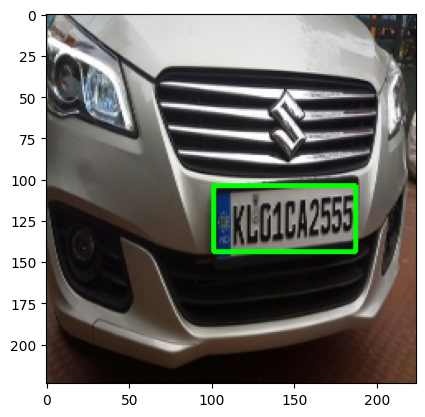

In [9]:
display_image(images[0], quadrant[0])

### NN Architecture

In [10]:
# Convolusional Neural Network Architecture
def create_model(input_shape):
    # Create sequential model
    model = models.Sequential()

    # Add layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))  # Convolutional layer | Input layer
    model.add(layers.MaxPooling2D((2, 2))) # Max pooling layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Convolutional layer
    model.add(layers.MaxPooling2D((2, 2))) # Max pooling layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu')) # Convolutional layer
    model.add(layers.Flatten()) # Flattening layer | Preparation for dense layer
    model.add(layers.Dense(512, activation='relu')) # Dense layer
    model.add(layers.Dense(4)) # Dense layer | Output layer (4 vertices)
    
    return model

### NN Training

In [11]:
# Create and compile the model
input_shape = images.shape[1:]  # height, width, channels
model = create_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(images, quadrant, epochs=10, batch_size=16, validation_split=0.05)

Epoch 1/10
34/34 [==============================] - 126s 3s/step - loss: 7727215.5000 - val_loss: 2488.8799
Epoch 2/10
34/34 [==============================] - 101s 3s/step - loss: 1904.1763 - val_loss: 2423.3411
Epoch 3/10
34/34 [==============================] - 99s 3s/step - loss: 1522.3726 - val_loss: 1934.5089
Epoch 4/10
34/34 [==============================] - 109s 3s/step - loss: 1158.9268 - val_loss: 1820.5767
Epoch 5/10
34/34 [==============================] - 103s 3s/step - loss: 973.5355 - val_loss: 1983.8168
Epoch 6/10
34/34 [==============================] - 102s 3s/step - loss: 839.8395 - val_loss: 1738.0864
Epoch 7/10
34/34 [==============================] - 104s 3s/step - loss: 711.1245 - val_loss: 1846.7844
Epoch 8/10
34/34 [==============================] - 102s 3s/step - loss: 856.0999 - val_loss: 1799.0056
Epoch 9/10
34/34 [==============================] - 102s 3s/step - loss: 753.0288 - val_loss: 1727.9542
Epoch 10/10
34/34 [==============================] - 101s 

In [12]:
# Save the model | .keras format
model.save('Control_Model_Detection_Augmented.keras')

### Evaluate the NN

##### Bounding-Box Predictions

In [1]:
# LOAD THE MODEL IF ALREADY TRAINED #
from tensorflow.keras.models import load_model

model = load_model('Control_Model_Detection.keras')

In [14]:
test_image_folder = r'augmented_control\test\images'
test_annotation_folder = r'augmented_control\test\labels'
test_images, test_quadrant = load_data(test_image_folder, test_annotation_folder)

In [15]:
predictions = model.predict(test_images)

1/1 [==============================] - 4s 4s/step


##### Display Image, True Quadrant (Green) and Predicted Quadrant (Blue)

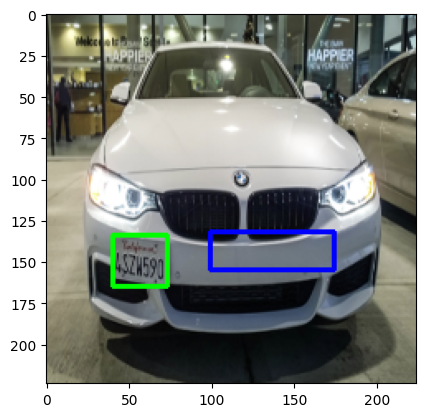

In [16]:
display_image(test_images[4], test_quadrant[4], predictions[4])

##### Evaluate Predictions: Jaccard Index

In [17]:
def Jaccard_Index(true_box, pred_box):

    # Calculate the intersection area
    xA = max(true_box[0], pred_box[0])
    yA = max(true_box[1], pred_box[1])
    xB = min(true_box[2], pred_box[2])
    yB = min(true_box[3], pred_box[3])

    intersection = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of both boxes
    trueBoxArea = (true_box[2] - true_box[0] + 1) * (true_box[3] - true_box[1] + 1)
    predBoxArea = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)

    # Calculate the union area
    union = trueBoxArea + predBoxArea - intersection

    # Calculate the Jaccard Index
    index = float(intersection) / float(union)

    return index


In [18]:
indices = []
for test_quad, pred_quad in zip(test_quadrant, predictions):
    index = Jaccard_Index(test_quad, pred_quad)
    indices.append(index)

mean_Jaccard = sum(indices) / len(indices)

print('Average Jaccard Index:', mean_Jaccard)

Average Jaccard Index: 0.2174263719254976


##### Evaluate Training: Jaccard

In [19]:
train_image_folder = r'control\train-valid\images'
train_annotation_folder = r'control\train-valid\labels'
train_images, train_quadrant = load_data(train_image_folder, train_annotation_folder)

In [20]:
predictions_Train = model.predict(train_images)

15/15 [==============================] - 6s 352ms/step


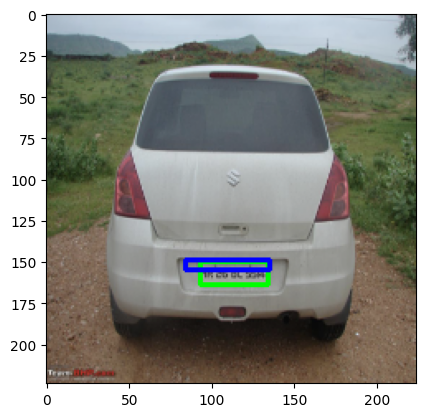

In [21]:
display_image(train_images[4], train_quadrant[4], predictions_Train[4])

In [22]:
indices = []
for train_quad, pred_train_quad in zip(train_quadrant, predictions_Train):
    index = Jaccard_Index(train_quad, pred_train_quad)
    indices.append(index)

mean_Jaccard = sum(indices) / len(indices)

print('Average Jaccard Index:', mean_Jaccard)

Average Jaccard Index: 0.32512484240611705
